#0. OBJETIVO DEL ANÁLISIS DE SERIES TEMPORAL

El objetivo de este cuaderno es mostrar los pasos a seguir al hacer un análisis de series temporal básico. El archivo cargado es un dataset ya limpio.

#1. IMPORTAR LIBRERÍAS NECESARIAS

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose #Para la descomposición
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing #Modelo ETS
from statsmodels.tsa.arima.model import ARIMA #Modelo Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX #Modelo Sarima
from sklearn.metrics import mean_absolute_error, mean_squared_error #métricas

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#2. CARGAR EL DATASET

In [ ]:
df = pd.read_csv('limpieza_eda_pildora.csv')
#Asegurarnos de que sea un dataframe
df=pd.DataFrame(df)

#3. DATA OVERVIEW

In [ ]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
df.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [ ]:
#Se hace una copia para no perder información en el csv original si se llega a hacer alguna modificación.
df_copy = df.copy()

#4. ANÁLISIS DE SERIES TEMPORAL

##4.1. ASEGURAR QUE DATE SEA FECHA Y EL ÍNDICE DEL DATAFRAME

Aunque se cambió el tipo de columna en la limpieza y EDA, al exportarlo no se mantienen los cambios, así que nos aseguramos ahora de que la fecha esté como tal.

Además, necesitamos que la fecha sea el índice del dataframe en este tipo de análisis.

In [ ]:
#Nos aseguramos que la columna de 'Date' sea una fecha y el índice del dataframe.
df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_copy.set_index('Date', inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73100 entries, 2022-01-01 to 2024-01-01
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store ID            73100 non-null  object 
 1   Product ID          73100 non-null  object 
 2   Category            73100 non-null  object 
 3   Region              73100 non-null  object 
 4   Inventory Level     73100 non-null  int64  
 5   Units Sold          73100 non-null  int64  
 6   Units Ordered       73100 non-null  int64  
 7   Demand Forecast     73100 non-null  float64
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 8.4+ MB


In [ ]:
#Convertir las columnas object a string
cols = ["Store ID", "Product ID", "Category", "Region", "Weather Condition", "Seasonality"]
df_copy[cols] = df_copy[cols].astype("string")

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73100 entries, 2022-01-01 to 2024-01-01
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store ID            73100 non-null  string 
 1   Product ID          73100 non-null  string 
 2   Category            73100 non-null  string 
 3   Region              73100 non-null  string 
 4   Inventory Level     73100 non-null  int64  
 5   Units Sold          73100 non-null  int64  
 6   Units Ordered       73100 non-null  int64  
 7   Demand Forecast     73100 non-null  float64
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  string 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  string 
dtypes: float64(3), int64(5), string(6)
memory usage: 8.4 MB


##4.2. DESCOMPOSICIÓN


Ayuda a comprender patrones, tendencias y variaciones estacionales en los datos.

Los componentes son:
- Tendencia (Trend): cómo evoluciona a largo plazo.
- Estacionalidad (Seasonality): patrones repetitivos (por ejemplo cada día, cada mes o cada año)
- Residuo (Resid): lo que queda cuando se quitan las dos anteriores.

In [ ]:
#Agrupamos las fechas para que solo haya una fila con una fecha.
df_daily = df_copy.groupby('Date')['Units Sold'].sum()

In [ ]:
df_daily.describe()

,Units Sold
count,731.000000
mean,13646.487004
std,1031.958966
min,10642.000000
25%,12981.000000
50%,13673.000000
75%,14323.500000
max,17239.000000


Nuestra serie temporal serán las unidades vendidas.

Ponemos la serie aditiva porque se ve que la estacionalidad es estable en torno a un valor y no va subiendo cada vez más.
- Serie = trend + seasonality + resid

El periodo que le vamos a poner será de 365 días.

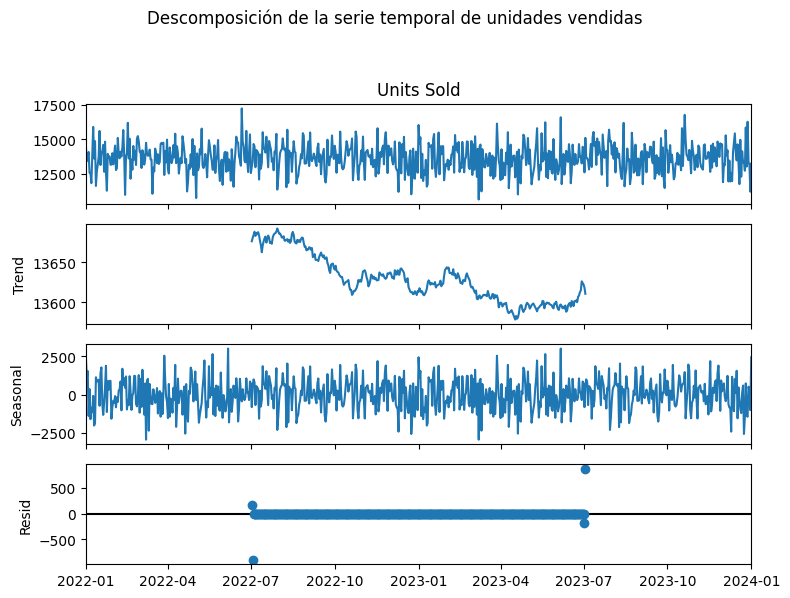

In [ ]:
#Descomposición en los componentes de la serie
decomposition = seasonal_decompose(df_daily, model='additive', period=365)

# Dibujamos la gráfica
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.suptitle('Descomposición de la serie temporal de unidades vendidas', y=1.02) #y=1.02 evita que se solapen los subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) #Estos números ajustan los márgenes
plt.show()

#El primer gráfico es lo observado

Conclusiones de la descomposición:

- Trend (evolución a largo plazo): Las ventas son estables pero tiene una ligera tendencia a decrecer en el tiempo.
- Seasonality (patrón repetitivo cada 365 días): no hay una estacionalidad (no hay patrones claros), por lo que las ventas probablemente no dependerán de ciclos.
- Resid (lo que queda sin trend ni seasonality): tenemos 4 outliers y el resto están en torno a 0. No los quitamos porque no hemos visto puntos raros en la limpieza y el EDA y queremos también que nuestro modelo sea robusto frente a eventos extremos.

El siguiente paso sería usar el modelo.


##4.3. MODELO CLÁSICO: Error - Trend - Seasonal (ETS)

###4.3.1. Sin split en train y test.

In [ ]:
#Modelo
model_ETS_365 = ExponentialSmoothing(
    df_daily,
    trend='add',
    seasonal='add',
    seasonal_periods=365
)

#Entrenamiento
fit_365 = model_ETS_365.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
#Resumen
print(fit_365.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Units Sold   No. Observations:                  731
Model:             ExponentialSmoothing   SSE                      410860800.234
Optimized:                         True   AIC                          10415.966
Trend:                         Additive   BIC                          12111.305
Seasonal:                      Additive   AICC                         11184.835
Seasonal Periods:                   365   Date:                 Wed, 11 Feb 2026
Box-Cox:                          False   Time:                         22:38:49
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.0654157                alpha                 True
smoothing_trend       

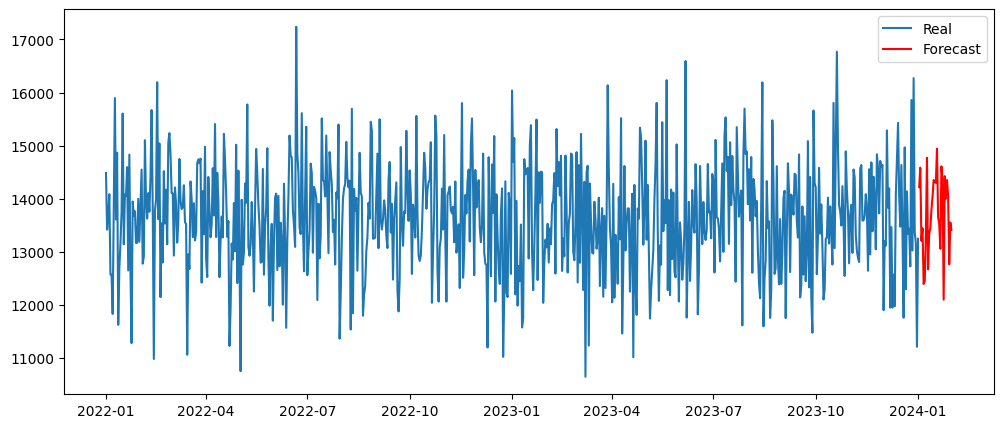

In [ ]:
#Gráfica con predicción (forecast)
forecast_365 = fit_365.forecast(30)

plt.figure(figsize=(12,5))
plt.plot(df_daily, label='Real')
plt.plot(forecast_365, label='Forecast',color='red')
plt.legend()
plt.show()

In [ ]:
#Para ver las predicciones
forecast_365 = fit_365.forecast(30)
print(forecast_365)

2024-01-02    14215.973680
2024-01-03    14582.385032
2024-01-04    13205.872429
2024-01-05    13439.561332
2024-01-06    12389.164582
2024-01-07    12445.324903
2024-01-08    13293.099650
2024-01-09    14768.568548
2024-01-10    12667.318816
2024-01-11    13348.005217
2024-01-12    13433.561451
2024-01-13    13785.786932
2024-01-14    14032.620017
2024-01-15    14350.730122
2024-01-16    14310.023291
2024-01-17    14298.821525
2024-01-18    14939.299560
2024-01-19    13650.532506
2024-01-20    13531.953222
2024-01-21    13054.999954
2024-01-22    14607.368816
2024-01-23    14341.478055
2024-01-24    12095.312569
2024-01-25    14423.669095
2024-01-26    13998.035676
2024-01-27    14349.973877
2024-01-28    14065.955534
2024-01-29    12762.766990
2024-01-30    13550.500504
2024-01-31    13411.338726
Freq: D, dtype: float64


No tenemos datos con los que comparar la exactitud de las predicciones, por lo que vamos a dividir una parte en train y otra en test para poder comparar las predicciones con valores reales y así poder obtener diferentes métricas y poder comparar con otros modelos.

###4.3.2. Con split en train y test.

Al hacer la división no debemos mezclar el pasado con el futuro. Se debe respetar el orden temporal.

In [ ]:
#Entrenamos con todo menos los últimos 30 días que serán la parte para testearlo.
train = df_daily.iloc[:-30]
test  = df_daily.iloc[-30:]

In [ ]:
#Modelo
model_ETS_split_7 = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=7
)
#Necesita tener mínimo el doble de datos, por eso usamos 7 y no 365.

#Entrenamiento
fit_7 = model_ETS_split_7.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
#Predicción con la parte de test.
y_pred = fit_7.forecast(len(test))

In [ ]:
#Resumen
print(fit_7.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Units Sold   No. Observations:                  701
Model:             ExponentialSmoothing   SSE                      780579374.292
Optimized:                         True   AIC                           9782.050
Trend:                         Additive   BIC                           9832.128
Seasonal:                      Additive   AICC                          9782.580
Seasonal Periods:                     7   Date:                 Wed, 11 Feb 2026
Box-Cox:                          False   Time:                         22:38:50
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0073998                alpha                 True
smoothing_trend          

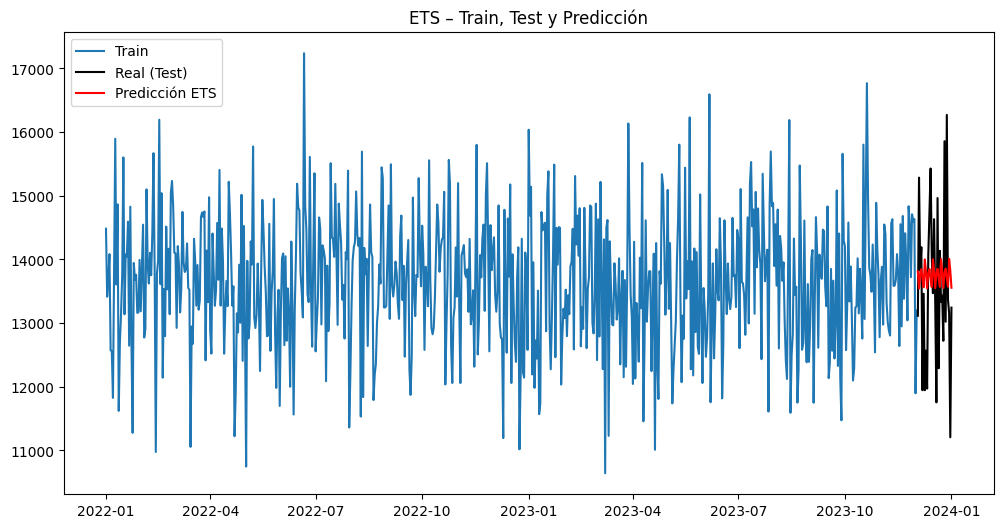

In [ ]:
#Gráfica con train, test y lo predicho para ETS (con split).
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Real (Test)', color='black')
plt.plot(y_pred.index, y_pred, label='Predicción ETS', color='red')
plt.legend()
plt.title('ETS – Train, Test y Predicción')
plt.show()

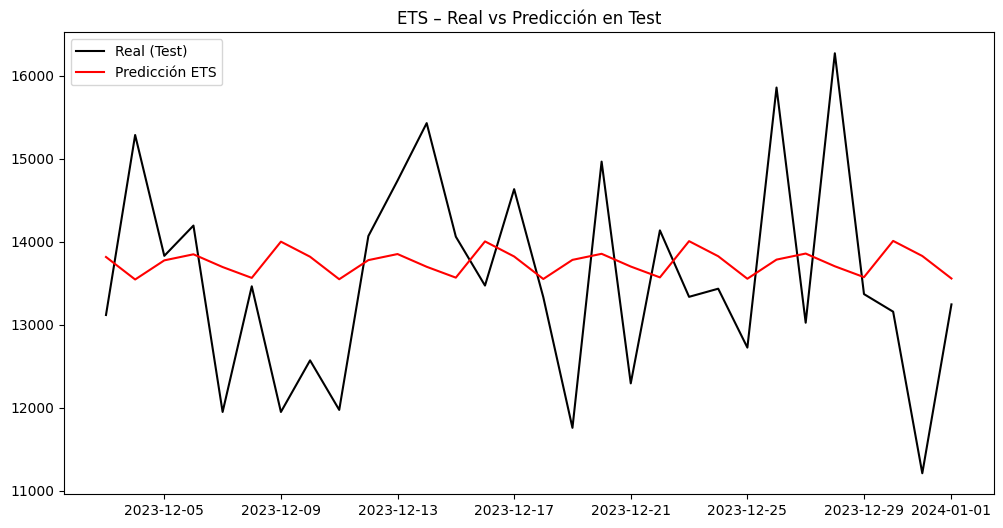

In [ ]:
#Gráfica con test y lo predicho.
plt.figure(figsize=(12,6))
# plt.plot(train.index, train, label='Train') # Eliminamos la parte de entrenamiento
plt.plot(test.index, test, label='Real (Test)', color='black')
plt.plot(y_pred.index, y_pred, label='Predicción ETS', color='red')
plt.legend()
plt.title('ETS – Real vs Predicción en Test')
plt.show()

In [ ]:
#Tabla con predicciones y errores
tabla_pred_errors = pd.DataFrame({
    "Real": test, #datos reales
    "Predicción": y_pred #datos predichos
}, index=test.index) #para que salga la columna de fecha como index


#Error absoluto (Real - Predicho)
tabla_pred_errors["Error"] = tabla_pred_errors["Real"] - tabla_pred_errors["Predicción"]

#Error en % ((|Real-Predicho|)/Real)*100
tabla_pred_errors["Error %"] = (
    tabla_pred_errors["Error"].abs() / tabla_pred_errors["Real"]
) * 100

print(tabla_pred_errors)

             Real    Predicción        Error    Error %
Date                                                   
2023-12-03  13116  13815.333100  -699.333100   5.331908
2023-12-04  15286  13544.038849  1741.961151  11.395795
2023-12-05  13829  13774.610878    54.389122   0.393298
2023-12-06  14194  13847.695461   346.304539   2.439795
2023-12-07  11947  13694.255874 -1747.255874  14.625060
2023-12-08  13462  13563.362255  -101.362255   0.752951
2023-12-09  11947  14000.146855 -2053.146855  17.185460
2023-12-10  12569  13818.335452 -1249.335452   9.939816
2023-12-11  11972  13547.041201 -1575.041201  13.156041
2023-12-12  14068  13777.613230   290.386770   2.064165
2023-12-13  14736  13850.697813   885.302187   6.007751
2023-12-14  15429  13697.258226  1731.741774  11.223940
2023-12-15  14060  13566.364607   493.635393   3.510920
2023-12-16  13471  14003.149207  -532.149207   3.950332
2023-12-17  14633  13821.337804   811.662196   5.546793
2023-12-18  13331  13550.043553  -219.043553   1

In [ ]:
#Calculamos MAE y RMSE
mae = mean_absolute_error(test, y_pred)
rmse = np.sqrt(mean_squared_error(test, y_pred))


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1033.34
RMSE: 1269.09


*   **MAE (Mean Absolute Error):** Mide el promedio de las diferencias absolutas entre las predicciones y los valores reales. Un MAE de 1033.34 significa que, en promedio, las predicciones se desvían en unas 1033.34 unidades de las ventas reales.

*   **RMSE (Root Mean Squared Error):** Es similar al MAE, pero penaliza más los errores grandes al elevar al cuadrado las diferencias antes de promediarlas y luego sacar la raíz cuadrada. Un RMSE de 1269.09 indica que la magnitud de los errores es un poco mayor, especialmente si hay valores atípicos o errores significativos.
* **R2 (R_score):** No se suele usar ya que los valores están autocorrelacionados, es decir, los valores cercanos en el tiempo normalmente se parecen entre sí. Los valores no son independientes.

In [ ]:
resumen_modelo = pd.DataFrame({
    "Modelo": ["ETS", "ETS"],
    "Seasonal period": [7, 365],
    "AIC": [fit_7.aic, fit_365.aic],
    "BIC": [fit_7.bic, fit_365.bic],
    "MAE": ["-" , mae],
    "RMSE": ["-" , rmse],
})

resumen_modelo

,Modelo,Seasonal period,AIC,BIC,MAE,RMSE
0,ETS,7,9782.050411,9832.127998,-,-
1,ETS,365,10415.965998,12111.304564,1033.337764,1269.087183


#4.4. MODELO ARIMA

In [ ]:
#Este modelo tiene estas variables: (p, d, q).
#p: número de observaciones de retardo (lag observations) en la serie.
#d: número de veces que se realizan las diferencias en los datos sin procesar.
#q: el tamaño de la ventana de media móvil.

# Usamos el orden (5,1,0) por defecto.
# Estos parámetros pueden ajustarse o buscarse automáticamente
model_arima = ARIMA(train, order=(5,1,0))
fit_arima = model_arima.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
#Predicciones
y_pred_arima = fit_arima.predict(start=len(train), end=len(df_daily)-1)

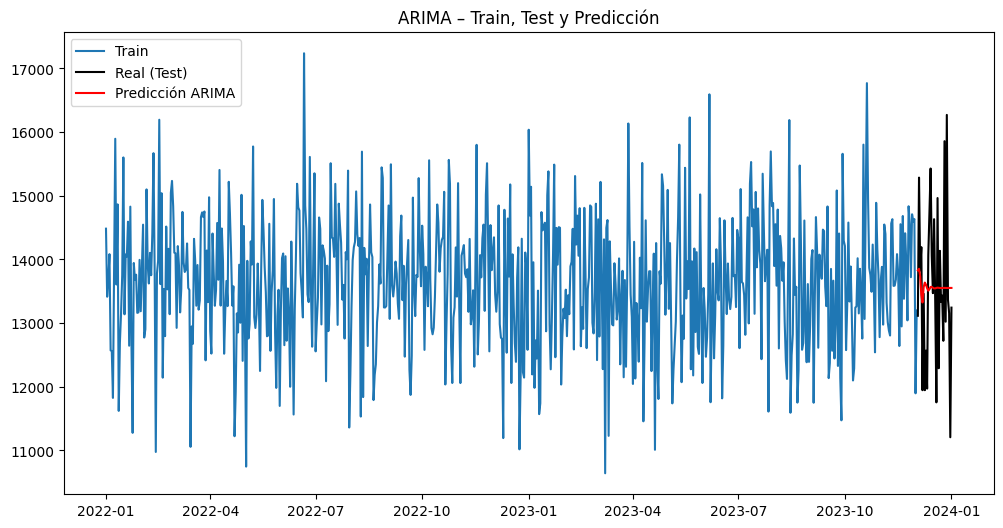

In [ ]:
#Gráfica con train, test y lo predicho para ARIMA.
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Real (Test)', color='black')
plt.plot(y_pred_arima.index, y_pred_arima, label='Predicción ARIMA', color='red')
plt.legend()
plt.title('ARIMA – Train, Test y Predicción')
plt.show()

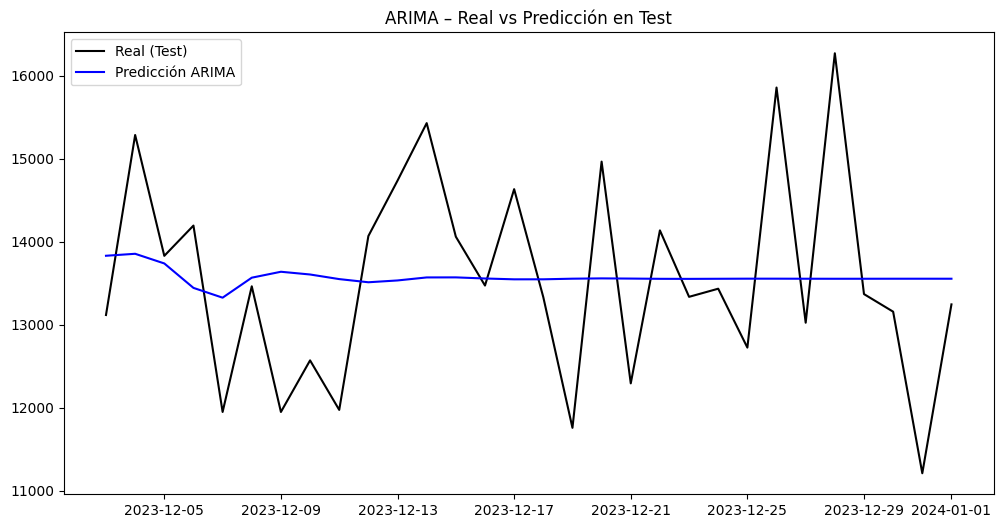

In [ ]:
#Gráfica con train, test y lo predicho para ARIMA.
plt.figure(figsize=(12,6))
# plt.plot(train.index, train, label='Train') # Eliminamos la parte de entrenamiento
plt.plot(test.index, test, label='Real (Test)', color='black')
plt.plot(y_pred_arima.index, y_pred_arima, label='Predicción ARIMA', color='blue')
plt.legend()
plt.title('ARIMA – Real vs Predicción en Test')
plt.show()

In [ ]:
#Calculamos MAE y RMSE para ARIMA
mae_arima = mean_absolute_error(test, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test, y_pred_arima))

print(f"MAE ARIMA: {mae_arima:.2f}")
print(f"RMSE ARIMA: {rmse_arima:.2f}")

MAE ARIMA: 976.01
RMSE ARIMA: 1222.30


#4.5. MODELO SARIMA

In [ ]:
# Además, de definir el orden (p, d, q) lo hacemos con el orden estacional (P, D, Q, s).
# Un punto de partida razonable para 's' es la estacionalidad diaria que hemos usado (7 días).

# Usamos como ejemplo el orden (1,1,1) y estacional (1,1,1,7)
# Estos parámetros pueden ajustarse o buscarse automáticamente (e.g., con auto_arima o grid search)
model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
fit_sarima = model_sarima.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
#Predicciones SARIMA
y_pred_sarima = fit_sarima.predict(start=len(train), end=len(df_daily)-1)

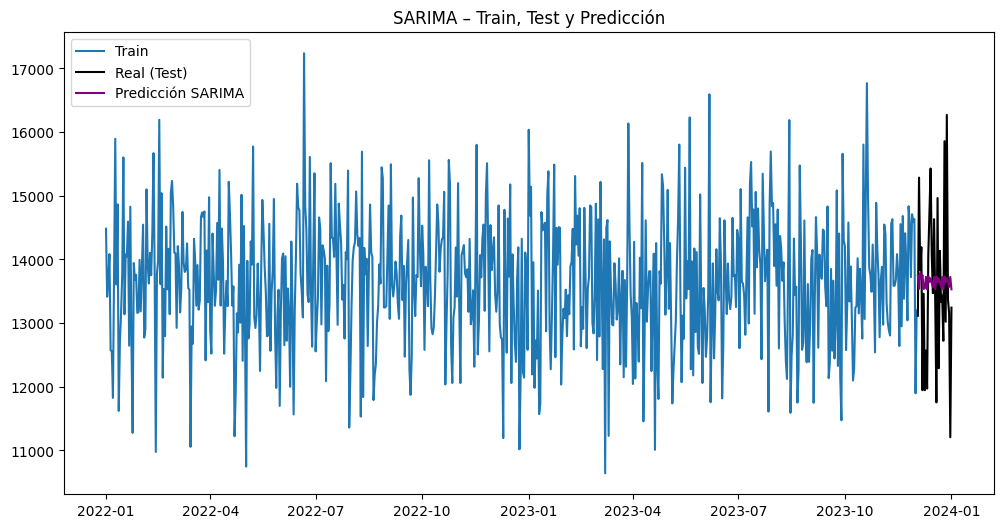

In [ ]:
#Gráfica con train, test y lo predicho para SARIMA.
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Real (Test)', color='black')
plt.plot(y_pred_sarima.index, y_pred_sarima, label='Predicción SARIMA', color='purple')
plt.legend()
plt.title('SARIMA – Train, Test y Predicción')
plt.show()

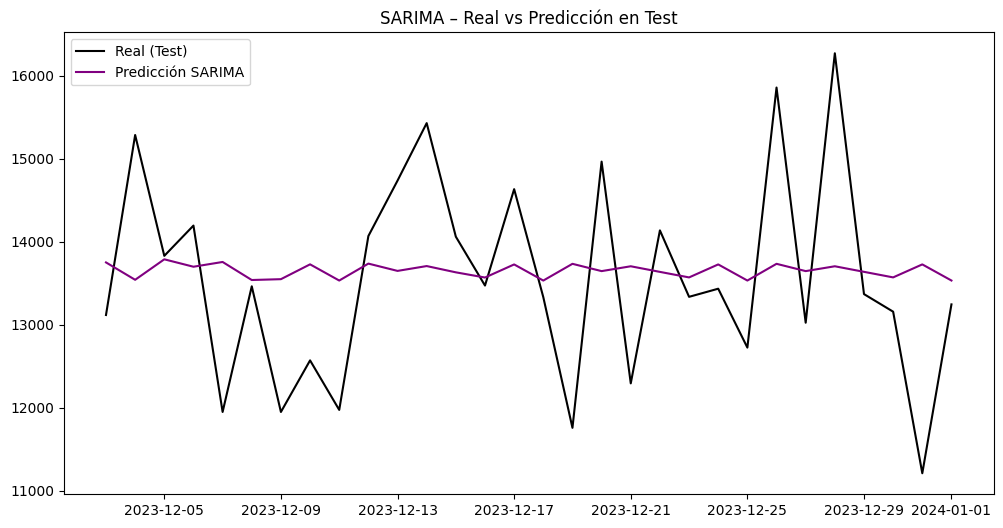

In [ ]:
#Gráfica con train, test y lo predicho para SARIMA.
plt.figure(figsize=(12,6))
# plt.plot(train.index, train, label='Train') # Eliminamos la parte de entrenamiento
plt.plot(test.index, test, label='Real (Test)', color='black')
plt.plot(y_pred_sarima.index, y_pred_sarima, label='Predicción SARIMA', color='purple')
plt.legend()
plt.title('SARIMA – Real vs Predicción en Test')
plt.show()

In [ ]:
#Calculamos MAE y RMSE para SARIMA
mae_sarima = mean_absolute_error(test, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, y_pred_sarima))

print(f"MAE SARIMA: {mae_sarima:.2f}")
print(f"RMSE SARIMA: {rmse_sarima:.2f}")

MAE SARIMA: 974.76
RMSE SARIMA: 1231.21


##4.3. ML TRADICIONALES: RANDOM FOREST Y XGBOOST.

In [ ]:
#Esta parte es común para ambos modelos.
#Se definen las variables
y = df_daily

#Features para que "entiendan el tiempo" estos modelos.
X = pd.DataFrame(index=df_daily.index)
X['year'] = X.index.year #Extrae el año
X['month'] = X.index.month #Extrae el mes
X['day'] = X.index.day #Extrae el día
X['dayofweek'] = X.index.dayofweek #Extrae el día de la semana

#Se hacen el split teniendo en cuenta el tiempo (sin mezclar pasado y futuro)
split_idx = int(len(X)*0.8) #80% train -20% test
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]



RMSE Random Forest: 1081.384
MAE Random Forest: 862.093


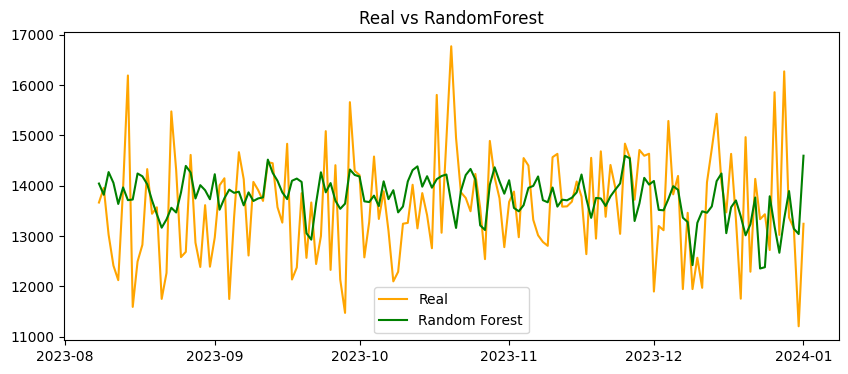

In [ ]:
#Modelo de RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#Predicciones
y_pred_rf = rf.predict(X_test)

#Métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf)) # Corrected to calculate RMSE

print(f"RMSE Random Forest: {rmse_rf:.3f}")
print(f"MAE Random Forest: {mae_rf:.3f}")


#Gráfica real vs randomforest
plt.figure(figsize=(10,4))
plt.plot(X_test.index, y_test, label='Real', color = 'orange')
plt.plot(X_test.index, y_pred_rf, label='Random Forest', color='green')
plt.legend()
plt.title('Real vs RandomForest')
plt.show()

RMSE XGBoost: 1281.192
MAE XGBoost: 1027.725


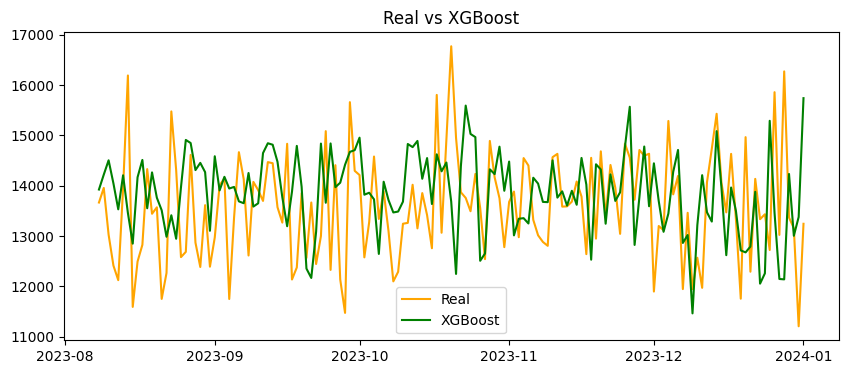

In [ ]:
#Modelo de XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

#Predicciones
y_pred_xgb = xgb_model.predict(X_test)

#Métricas
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb)) # Corrected to calculate RMSE
print(f"RMSE XGBoost: {rmse_xgb:.3f}")
print(f"MAE XGBoost: {mae_xgb:.3f}")

#Gráfica real vs XGBoost
plt.figure(figsize=(10,4))
plt.plot(X_test.index, y_test, label='Real', color = 'orange')
plt.plot(X_test.index, y_pred_xgb, label='XGBoost', color='green')
plt.legend()
plt.title('Real vs XGBoost')
plt.show()


##4.4. COMPARACIÓN ENTRE MODELOS

In [ ]:
#Reconstruimos la tabla resumen con los resultados de todos los modelos
resumen_modelo = pd.DataFrame({
    "Modelo": ["ETS", "ETS", "RF", "XGBoost", "ARIMA", "SARIMA"],
    "Seasonal period": [7, 365, "-", "-", "-", 7],
    "AIC": [fit_7.aic, fit_365.aic, "-", "-", fit_arima.aic, fit_sarima.aic],
    "BIC": [fit_7.bic, fit_365.bic, "-", "-", fit_arima.bic, fit_sarima.bic],
    "MAE": ["-" , mae, mae_rf, mae_xgb, mae_arima, mae_sarima],
    "RMSE": ["-" , rmse, rmse_rf, rmse_xgb, rmse_arima, rmse_sarima]
})

resumen_modelo

,Modelo,Seasonal period,AIC,BIC,MAE,RMSE
0,ETS,7,9782.050411,9832.127998,-,-
1,ETS,365,10415.965998,12111.304564,1033.337764,1269.087183
2,RF,-,-,-,862.093333,1081.383575
3,XGBoost,-,-,-,1027.72522,1281.192023
4,ARIMA,-,11818.9806,11846.287082,976.011714,1222.301846
5,SARIMA,7,11679.148079,11701.853229,974.755764,1231.205627
